In [58]:

import pandas as pd
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Get the file path from the environment variable
#file_path = os.getenv('FILE_PATH')
file_path = "C:/Users/amita/team_lambda/Data/stock_and_econ.xlsx"

df= pd.read_excel(file_path)




In [59]:
print("Shape of the dataset:", df.shape)  # Number of rows and columns
print("First 5 rows of the dataset:")
print(df.head())  # Display the first 5 rows

Shape of the dataset: (41439, 49)
First 5 rows of the dataset:
  Ticker                Long Name As Of Date Quarter  Year  Label  \
0    MMM                    3M CO 2024-12-31      Q4  2024      0   
1    ABT      ABBOTT LABORATORIES 2024-12-31      Q4  2024      0   
2   ABBV               ABBVIE INC 2024-12-31      Q4  2024      0   
3  ACNCL       ACCENTURE PLC-CL A 2024-12-31      Q4  2024      0   
4   ATVI  ACTIVISION BLIZZARD INC 2024-12-31      Q4  2024      0   

   Market Value (%)   Div Yld        P/E       P/CF  ...  GDP CYOY Index  \
0          0.112978  2.169029  12.125959  36.257446  ...             2.5   
1          0.098993  2.086464  31.060309  22.592426  ...             2.5   
2          0.155521  3.691615  23.327688  19.046702  ...             2.5   
3          0.307883  1.682822  28.674432  22.861091  ...             2.5   
4               NaN       NaN        NaN        NaN  ...             2.5   

   EHUPUS Index  CONCCONF Index  USYC2Y10 Index  CSI BARC Index  

In [60]:
# Step 2: Check for missing values
missing_pct = (df.isnull().sum() / len(df)) * 100
print("Percentage of missing values in each column:")
print(missing_pct.sort_values(ascending=False))

Percentage of missing values in each column:
Inv Gr              40.119211
Div Yld             33.067883
Work Cap Gr         30.490601
FCF Gr_2            28.082241
P/FCF               27.614083
FCF Gr              27.071117
ROC                 22.686358
Current Ratio       22.220613
P/EBITDA            21.462873
Div Pay Ratio       20.415551
5yr Avg P/E         19.788122
BEst Div Yld        18.912136
EBITDA Gr           18.557398
Debt/EBITDA         17.131205
Earn Yld            17.015372
P/E                 17.015372
P/CF                15.463694
P/B                 14.942446
FCF Yld             14.754217
ROE                 14.604600
Free CF             13.443857
Debt/Equity         12.847800
CF Gr               11.595357
Op Inc Gr           11.332320
Net Inc Gr          11.095828
Op Margin           10.835204
ROA                 10.789353
Profit Margin       10.297063
Market Value (%)    10.166751
year_inco            3.928666
Sector               3.571515
CPI YOY Index        2.70

In [61]:
# Separate by missingness level
high_missing = missing_pct[missing_pct > 30].index.tolist()
moderate_missing = missing_pct[(missing_pct > 10) & (missing_pct <= 30)].index.tolist()
low_missing = missing_pct[(missing_pct > 0) & (missing_pct <= 10)].index.tolist()
no_missing = missing_pct[missing_pct == 0].index.tolist()


Columns with High Missing Values (>30%):
Columns like Inv Gr (40.12%) and Div Yld (33.07%) have a high percentage of missing values, dropping thise columns.


In [62]:
columns_to_drop = ['Inv Gr', 'Work Cap Gr','Div Yld']
df.drop(columns=columns_to_drop, axis=1, inplace=True)
print(f"Dropped columns: {columns_to_drop}")

Dropped columns: ['Inv Gr', 'Work Cap Gr', 'Div Yld']


In [63]:
# MODERATE MISSINGNESS: Impute using Iterative Imputer (MICE)
# These are valuable Buffett signals (P/FCF, ROE, etc.)
important_features = ['P/FCF', 'ROE', 'FCF Gr', 'Debt/Equity']
mice_features = [f for f in important_features if f in df.columns]

In [64]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp_mice = IterativeImputer(random_state=42)
df[mice_features] = imp_mice.fit_transform(df[mice_features])

In [65]:
#LOW MISSINGNESS: Impute with mean (low risk)
from sklearn.impute import SimpleImputer

low_missing_numeric = [col for col in low_missing if pd.api.types.is_numeric_dtype(df[col])]

mean_imputer = SimpleImputer(strategy='mean')
df[low_missing_numeric] = mean_imputer.fit_transform(df[low_missing_numeric])




In [66]:
 #Show updated missing values (should be mostly 0s now)
print("\nRemaining missingness after handling:")
print(df.isnull().sum()[df.isnull().sum() > 0])


Remaining missingness after handling:
Market Value (%)     4213
P/E                  7051
P/CF                 6408
P/B                  6192
Current Ratio        9208
BEst Div Yld         7837
ROA                  4471
Op Margin            4490
Profit Margin        4267
Debt/EBITDA          7099
P/EBITDA             8894
FCF Yld              6114
Div Pay Ratio        8460
Free CF              5571
Earn Yld             7051
5yr Avg P/E          8200
CF Gr                4805
EBITDA Gr            7690
FCF Gr_2            11637
Net Inc Gr           4598
Op Inc Gr            4696
ROC                  9401
Sector               1480
dtype: int64


In [67]:
print(df.dtypes[df.dtypes == 'object'])

Ticker       object
Long Name    object
Quarter      object
Sector       object
dtype: object


In [68]:
# 2. Choose numeric features for model-based imputation (skip IDs/dates/labels)
import numpy as np
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['Year', 'Quarter', 'Label', 'Market Value (%)']  # Add any others you want to preserve
impute_cols = [col for col in numeric_cols if col not in exclude_cols]

In [69]:
# 3. Re-run MICE on broader set
imp_full = IterativeImputer(random_state=42, max_iter=10)
df[impute_cols] = imp_full.fit_transform(df[impute_cols])

c:\Users\amita\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [70]:
# 4. Check missingness again
remaining_missing = df.isnull().sum()[df.isnull().sum() > 0]
print("\nMissing values after full imputation:\n", remaining_missing)


Missing values after full imputation:
 Market Value (%)    4213
Sector              1480
dtype: int64


In [71]:
# Impute 'Sector' with mode or fillna("Unknown")
df['Sector'] = df['Sector'].fillna(df['Sector'].mode()[0])

In [72]:
# Impute 'Market Value (%)' by median sector-wise
df['Market Value (%)'] = df.groupby('Sector')['Market Value (%)'].transform(
    lambda x: x.fillna(x.median())
)

In [73]:
# 4. Check missingness again
remaining_missing = df.isnull().sum()[df.isnull().sum() > 0]
print("\nMissing values after full imputation:\n", remaining_missing)


Missing values after full imputation:
 Series([], dtype: int64)


In [74]:
# Step 4: Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 2240


In [75]:
# Remove duplicate rows
df = df.drop_duplicates()
print(f"Shape of the dataset after removing duplicates: {df.shape}")

Shape of the dataset after removing duplicates: (39199, 46)


In [76]:
# Verify that no duplicate rows remain
duplicate_rows_after = df.duplicated().sum()
print(f"Number of duplicate rows after removal: {duplicate_rows_after}")

Number of duplicate rows after removal: 0


In [77]:
# Step 6: Analyze the distribution of the target variable
print("Distribution of the target variable:")
print(df['Label'].value_counts(normalize=True) * 100)

Distribution of the target variable:
Label
0    98.795888
1     1.204112
Name: proportion, dtype: float64


target variable is highly imbalanced — only about 1.2% of observations are "stocks Buffett bought" (Label = 1), which can severely bias  model toward always predicting 0.
we will use the XGBoost technique to hanlde the class imbalance 

 Feature Engineering Code

COVID_Period captures a nonlinear temporal shock (pandemic), which impacted different sectors differently.

Profit_Per_Leverage reflects return on equity relative to how much debt the company takes on — something Buffett is likely to care about.

PE_Category simplifies a noisy continuous variable into interpretable categories, which improves model interpretability and stability.

In [78]:
# 1. COVID Period Flag (Assuming 'As Of Date' is in datetime format)
df['As Of Date'] = pd.to_datetime(df['As Of Date'])
df['COVID_Period'] = ((df['As Of Date'] >= '2020-03-01') & (df['As Of Date'] <= '2021-12-31')).astype(int)
# Sort and group
df = df.sort_values(by=['Ticker', 'As Of Date'])

# Create lagged COVID flag
df['COVID_Period_Lag1'] = df.groupby('Ticker')['COVID_Period'].shift(1)



In [79]:
# 2. Profit Per Leverage (ROE / Debt-to-Equity)
df['Profit_Per_Leverage'] = df['ROE'] / (df['Debt/Equity'] + 1e-5)


In [80]:
# 3. Binned P/E Ratio into Buffett-style logic
def categorize_pe(pe):
    if pd.isna(pe):
        return 'Missing'
    elif pe < 0:
        return 'Negative'
    elif pe < 10:
        return 'Low'
    elif pe < 25:
        return 'Good'
    elif pe < 40:
        return 'High'
    else:
        return 'Craziness'

In [81]:
df['PE_Category'] = df['P/E'].apply(categorize_pe)

In [82]:
df['PE_Category'] = pd.Categorical(df['PE_Category'], 
                                   categories=['Negative', 'Low', 'Good', 'High', 'Craziness', 'Missing'],
                                   ordered=True)

collapsing Variables
Justifications:
Collapsing Rare Categories:
In the Sector column, rare categories (e.g., those with <5% frequency) were grouped into an "Other" category.

Justification: Reduces noise and prevents overfitting by simplifying the categorical variable.


In [83]:
# Count and percentage of each sector
sector_counts = df['Sector'].value_counts()
sector_percentages = df['Sector'].value_counts(normalize=True) * 100

# Combine counts and percentages into a single DataFrame for better readability
sector_summary = pd.DataFrame({
    'Count': sector_counts,
    'Percentage (%)': sector_percentages
})

# Display the sector summary
print(sector_summary)

                                                 Count  Percentage (%)
Sector                                                                
Software & IT Services                            4900       12.500319
Residential & Commercial REIT                     2030        5.178704
Machinery, Equipment & Components                 1890        4.821552
Healthcare Equipment & Supplies                   1820        4.642976
Insurance                                         1610        4.107248
Electrical Utilities & IPPs                       1610        4.107248
Investment Banking & Investment Services          1610        4.107248
Pharmaceuticals                                   1399        3.568969
Hotels & Entertainment Services                   1330        3.392944
Food & Tobacco                                    1260        3.214368
Banking Services                                  1260        3.214368
Media & Publishing                                1260        3.214368
Profes

In [28]:
sector_counts = df['Sector'].value_counts(normalize=True)
rare_sectors = sector_counts[sector_counts < 0.03].index
df['Sector'] = df['Sector'].replace(rare_sectors, 'Other')

In [84]:
df.columns

Index(['Ticker', 'Long Name', 'As Of Date', 'Quarter', 'Year', 'Label',
       'Market Value (%)', 'P/E', 'P/CF', 'P/B', 'Debt/Equity',
       'Current Ratio', 'BEst Div Yld', 'ROE', 'ROA', 'Op Margin',
       'Profit Margin', 'Debt/EBITDA', 'P/EBITDA', 'FCF Gr', 'FCF Yld',
       'P/FCF', 'Div Pay Ratio', 'Free CF', 'Earn Yld', '5yr Avg P/E', 'CF Gr',
       'EBITDA Gr', 'FCF Gr_2', 'Net Inc Gr', 'Op Inc Gr', 'ROC', 'FDTR Index',
       'GT10 Govt', 'CPI YOY Index', 'PPI YOY Index', 'GDP CYOY Index',
       'EHUPUS Index', 'CONCCONF Index', 'USYC2Y10 Index', 'CSI BARC Index',
       'SPX Index PE', 'VIX Index', 'BBGCUSDI Index', 'Sector', 'year_inco',
       'COVID_Period', 'COVID_Period_Lag1', 'Profit_Per_Leverage',
       'PE_Category'],
      dtype='object')

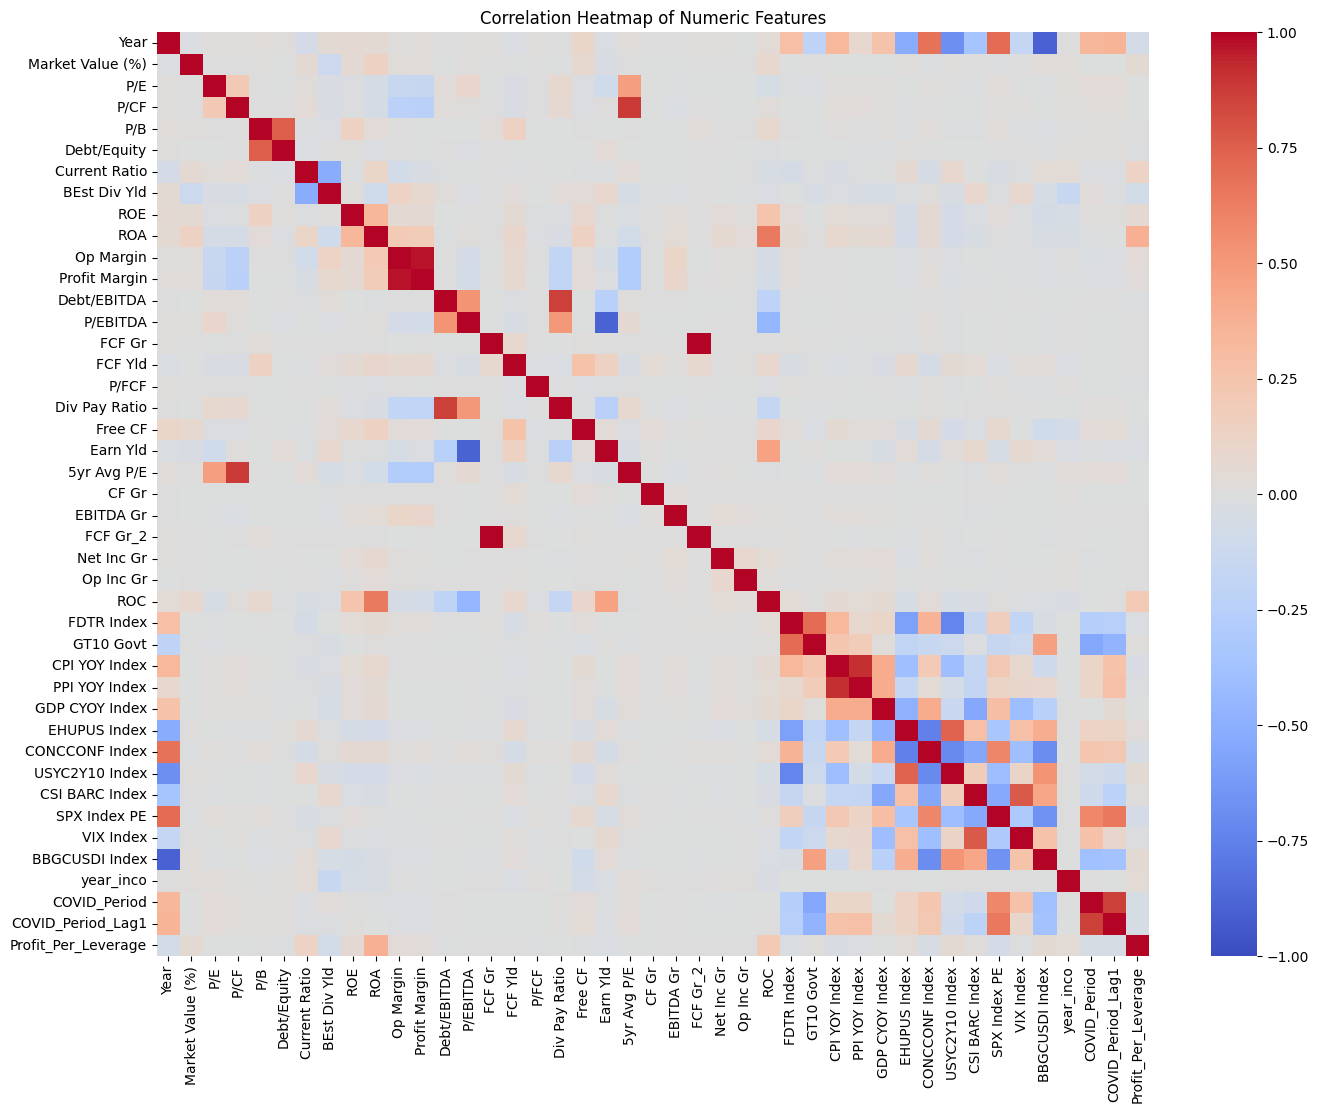

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Select only numeric columns (excluding identifiers, labels, etc.)
numeric_df = df.select_dtypes(include='number').drop(columns=['Label'])  # Keep label for target prediction

# Step 2: Compute correlation matrix
corr_matrix = numeric_df.corr()

# Step 3: Plot heatmap (correlation > 0.8 or < -0.8 are suspect)
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


PPI YOY Index:

Justification: Highly correlated with CPI YOY Index (positive correlation close to 1). Both represent inflation metrics, and retaining CPI YOY Index is sufficient as it is more commonly used in economic analysis.

Debt/EBITDA:

Justification: Strong positive correlation with Debt/Equity. Both measure financial leverage, but Debt/Equity is more widely used and interpretable in financial analysis.

FCF Gr_2:

Justification: Highly correlated with FCF Gr. Both represent free cash flow growth, and retaining FCF Gr is sufficient to capture this information.

EHUPUS Index :

Justification: Moderately correlated with GDP CYOY Index. Both represent economic growth trends, but GDP CYOY Index is more standard and interpretable for macroeconomic analysis.

COVID_Period_Lag1:

Justification: Highly correlated with COVID_Period. Both represent temporal information related to the COVID-19 period, and retaining COVID_Period is sufficient

In [86]:
# List of columns to drop
columns_to_drop = ['PPI YOY Index', 'Debt/EBITDA', 'FCF Gr_2', 'EHUPUS Index', 'COVID_Period_Lag1']

# Drop the columns from the DataFrame
df = df.drop(columns=columns_to_drop)

# Verify the columns have been dropped
print("Remaining columns:", df.columns)

Remaining columns: Index(['Ticker', 'Long Name', 'As Of Date', 'Quarter', 'Year', 'Label',
       'Market Value (%)', 'P/E', 'P/CF', 'P/B', 'Debt/Equity',
       'Current Ratio', 'BEst Div Yld', 'ROE', 'ROA', 'Op Margin',
       'Profit Margin', 'P/EBITDA', 'FCF Gr', 'FCF Yld', 'P/FCF',
       'Div Pay Ratio', 'Free CF', 'Earn Yld', '5yr Avg P/E', 'CF Gr',
       'EBITDA Gr', 'Net Inc Gr', 'Op Inc Gr', 'ROC', 'FDTR Index',
       'GT10 Govt', 'CPI YOY Index', 'GDP CYOY Index', 'CONCCONF Index',
       'USYC2Y10 Index', 'CSI BARC Index', 'SPX Index PE', 'VIX Index',
       'BBGCUSDI Index', 'Sector', 'year_inco', 'COVID_Period',
       'Profit_Per_Leverage', 'PE_Category'],
      dtype='object')


In [87]:
# Step 1: Drop irrelevant columns
columns_to_drop = ['Ticker', 'Long Name', 'As Of Date']
df = df.drop(columns=columns_to_drop)

In [88]:
print("Remaining columns:", df.columns)

Remaining columns: Index(['Quarter', 'Year', 'Label', 'Market Value (%)', 'P/E', 'P/CF', 'P/B',
       'Debt/Equity', 'Current Ratio', 'BEst Div Yld', 'ROE', 'ROA',
       'Op Margin', 'Profit Margin', 'P/EBITDA', 'FCF Gr', 'FCF Yld', 'P/FCF',
       'Div Pay Ratio', 'Free CF', 'Earn Yld', '5yr Avg P/E', 'CF Gr',
       'EBITDA Gr', 'Net Inc Gr', 'Op Inc Gr', 'ROC', 'FDTR Index',
       'GT10 Govt', 'CPI YOY Index', 'GDP CYOY Index', 'CONCCONF Index',
       'USYC2Y10 Index', 'CSI BARC Index', 'SPX Index PE', 'VIX Index',
       'BBGCUSDI Index', 'Sector', 'year_inco', 'COVID_Period',
       'Profit_Per_Leverage', 'PE_Category'],
      dtype='object')


selecting these  below columns because they represent a mix of financial metrics, macroeconomic indicators, and categorical/time-based features that are likely to influence an investor's decision to purchase a stock.

In [89]:
selected_columns = [
    'Market Value (%)','P/E', 'P/CF', 'P/B', 'Debt/Equity', 'ROE', 'ROA', 'Profit Margin',
'Op Margin', 'FCF Gr', 'EBITDA Gr', 'Net Inc Gr', 'GDP CYOY Index',
'CPI YOY Index', 'VIX Index', 'Sector', 'Quarter', 'Year', 'Label'
,'COVID_Period','Profit_Per_Leverage', 'PE_Category'
]

In [90]:
df = df[selected_columns]

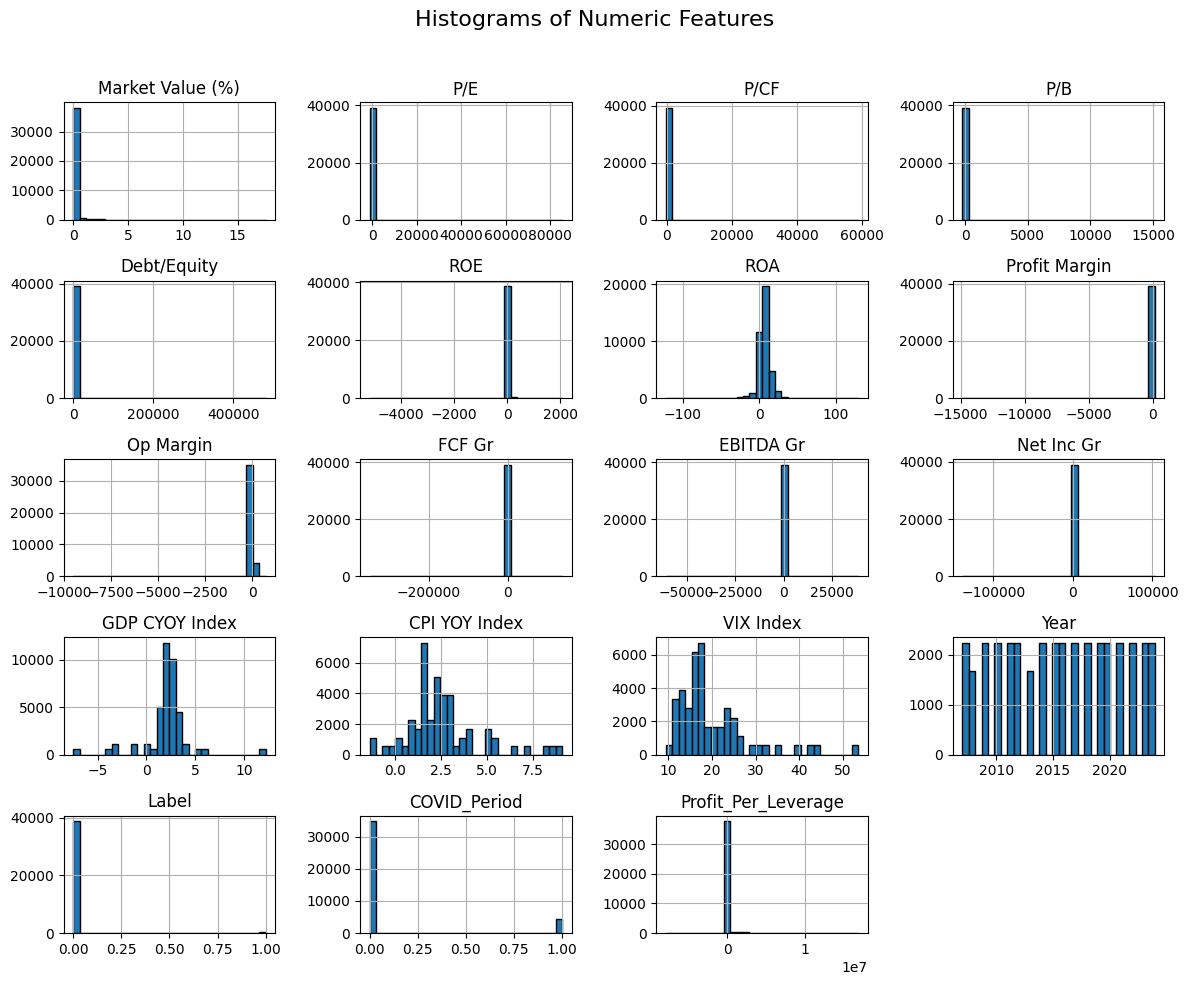

In [91]:
import matplotlib.pyplot as plt

df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Histograms of Numeric Features', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

P/E, P/CF, P/B, Debt/Equity, FCF Gr, , Profit Margin,Market value %
These features are highly right skewed , with most values concentraed near zero and few extreme outliers on the higher end.

we will consider handling outliers or applying transformations to reduce skewness.

Mathematical Transformations

Applied to features with extreme outliers to cap values at the 1st and 99th percentiles.

In [95]:
import numpy as np

# List of features to apply Winsorization
features_to_winsorize = ['Market Value (%)', 'P/E', 'P/CF', 'P/B', 'Debt/Equity',
                         'Profit Margin', 'Op Margin', 'FCF Gr', 'EBITDA Gr', 'Net Inc Gr']

# Apply Winsorization to each feature
for feature in features_to_winsorize:
    lower_bound = df[feature].quantile(0.01)  # 1st percentile
    upper_bound = df[feature].quantile(0.99)  # 99th percentile
    df[feature] = np.clip(df[feature], lower_bound, upper_bound)

# Verify the changes
print("Winsorization applied to the following features:")
print(features_to_winsorize)

Winsorization applied to the following features:
['Market Value (%)', 'P/E', 'P/CF', 'P/B', 'Debt/Equity', 'Profit Margin', 'Op Margin', 'FCF Gr', 'EBITDA Gr', 'Net Inc Gr']


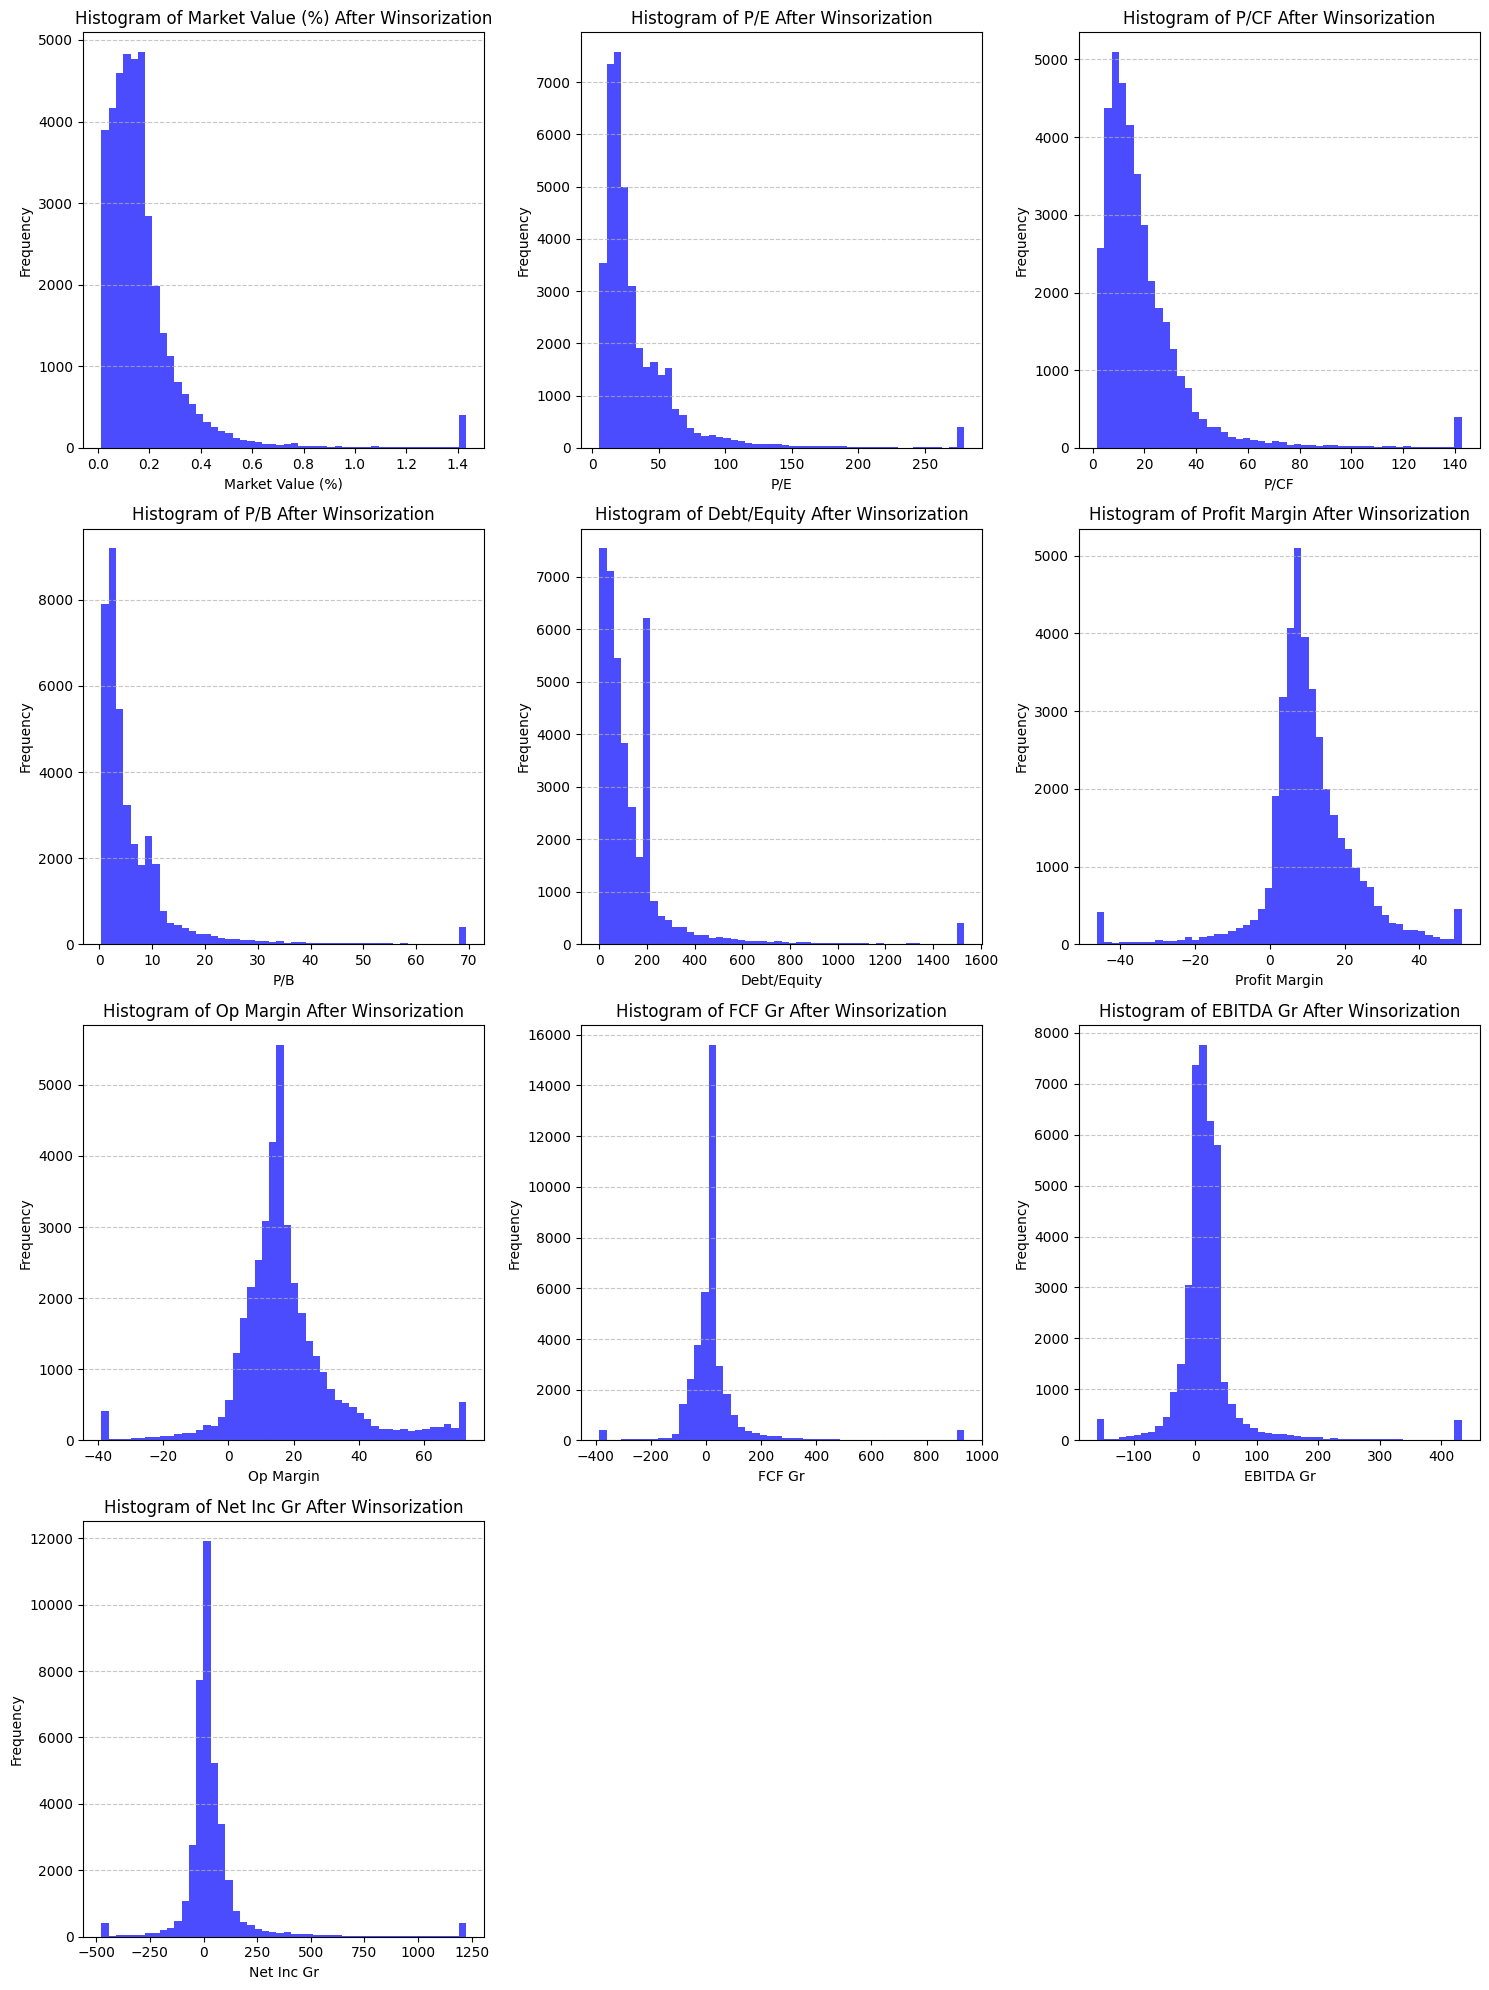

In [96]:
import matplotlib.pyplot as plt

# List of features to visualize
features_to_winsorize = ['Market Value (%)', 'P/E', 'P/CF', 'P/B', 'Debt/Equity',
                         'Profit Margin', 'Op Margin', 'FCF Gr', 'EBITDA Gr', 'Net Inc Gr']

# Set up the grid for subplots
num_features = len(features_to_winsorize)
cols = 3  # Number of columns in the grid
rows = (num_features + cols - 1) // cols  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot each feature's histogram
for i, feature in enumerate(features_to_winsorize):
    axes[i].hist(df[feature], bins=50, color='blue', alpha=0.7)
    axes[i].set_title(f"Histogram of {feature} After Winsorization")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Frequency")
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

boxplot:  outliers and confirm their reduction after applying techniques like winsorization.

C:\Users\amita\AppData\Local\Temp\ipykernel_29432\2943945095.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Feature', y='Value', data=melted_df, palette='Set2')


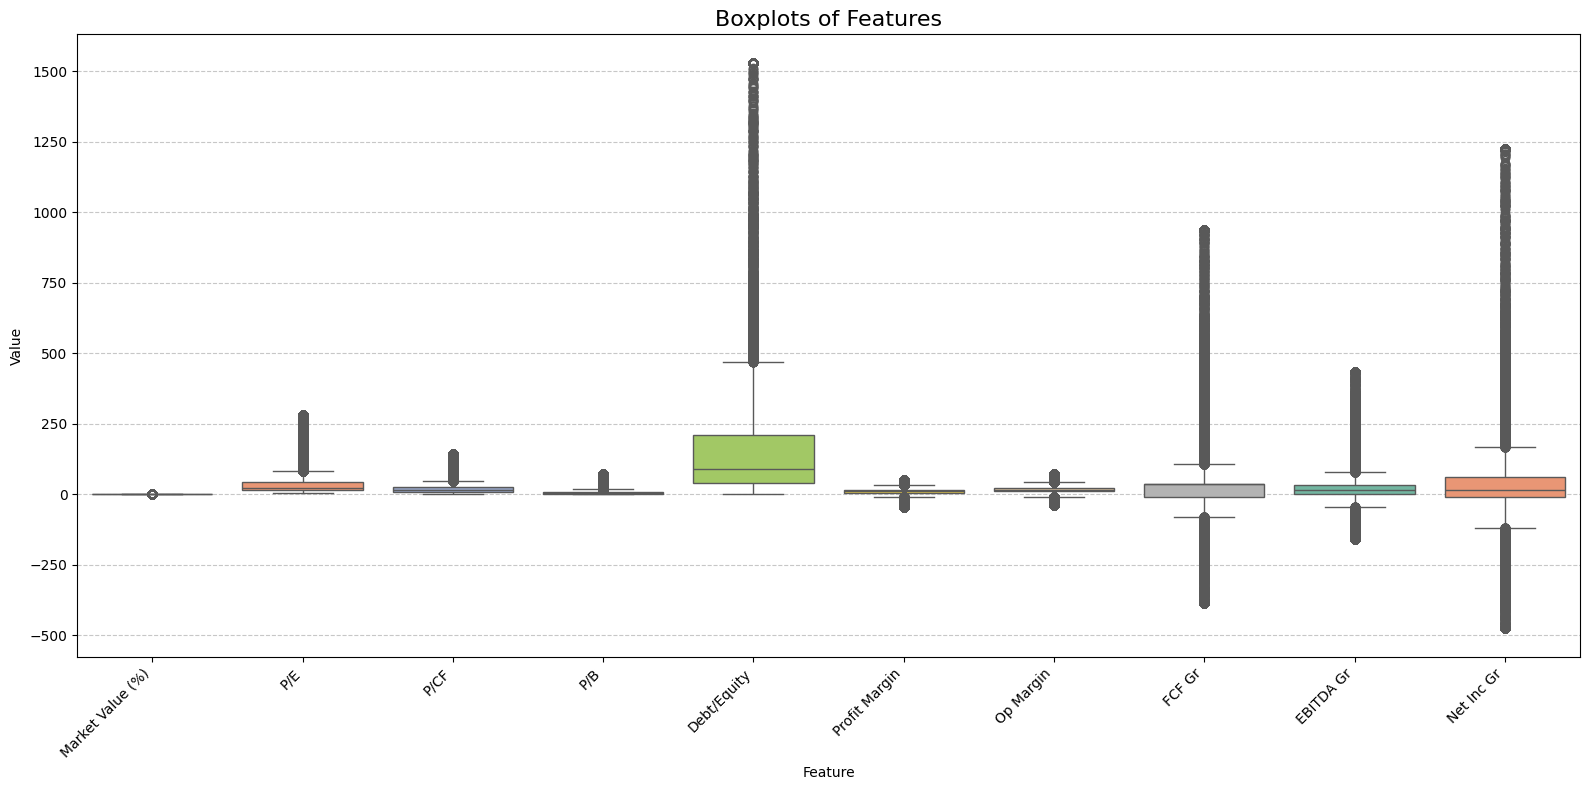

In [97]:
# import seaborn as sns

# # Plot boxplots for each feature
# for feature in features_to_winsorize:
#     plt.figure(figsize=(8, 4))
#     sns.boxplot(x=df[feature], color='green')
#     plt.title(f"Boxplot of {feature}")
#     plt.xlabel(feature)
#     plt.grid(axis='y', linestyle='--', alpha=0.7)
#     plt.show()

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Melt the DataFrame to reshape it for a single boxplot
melted_df = df[features_to_winsorize].melt(var_name='Feature', value_name='Value')

# Plot all boxplots in one graph
plt.figure(figsize=(16, 8))
sns.boxplot(x='Feature', y='Value', data=melted_df, palette='Set2')
plt.title('Boxplots of Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

 log transformation

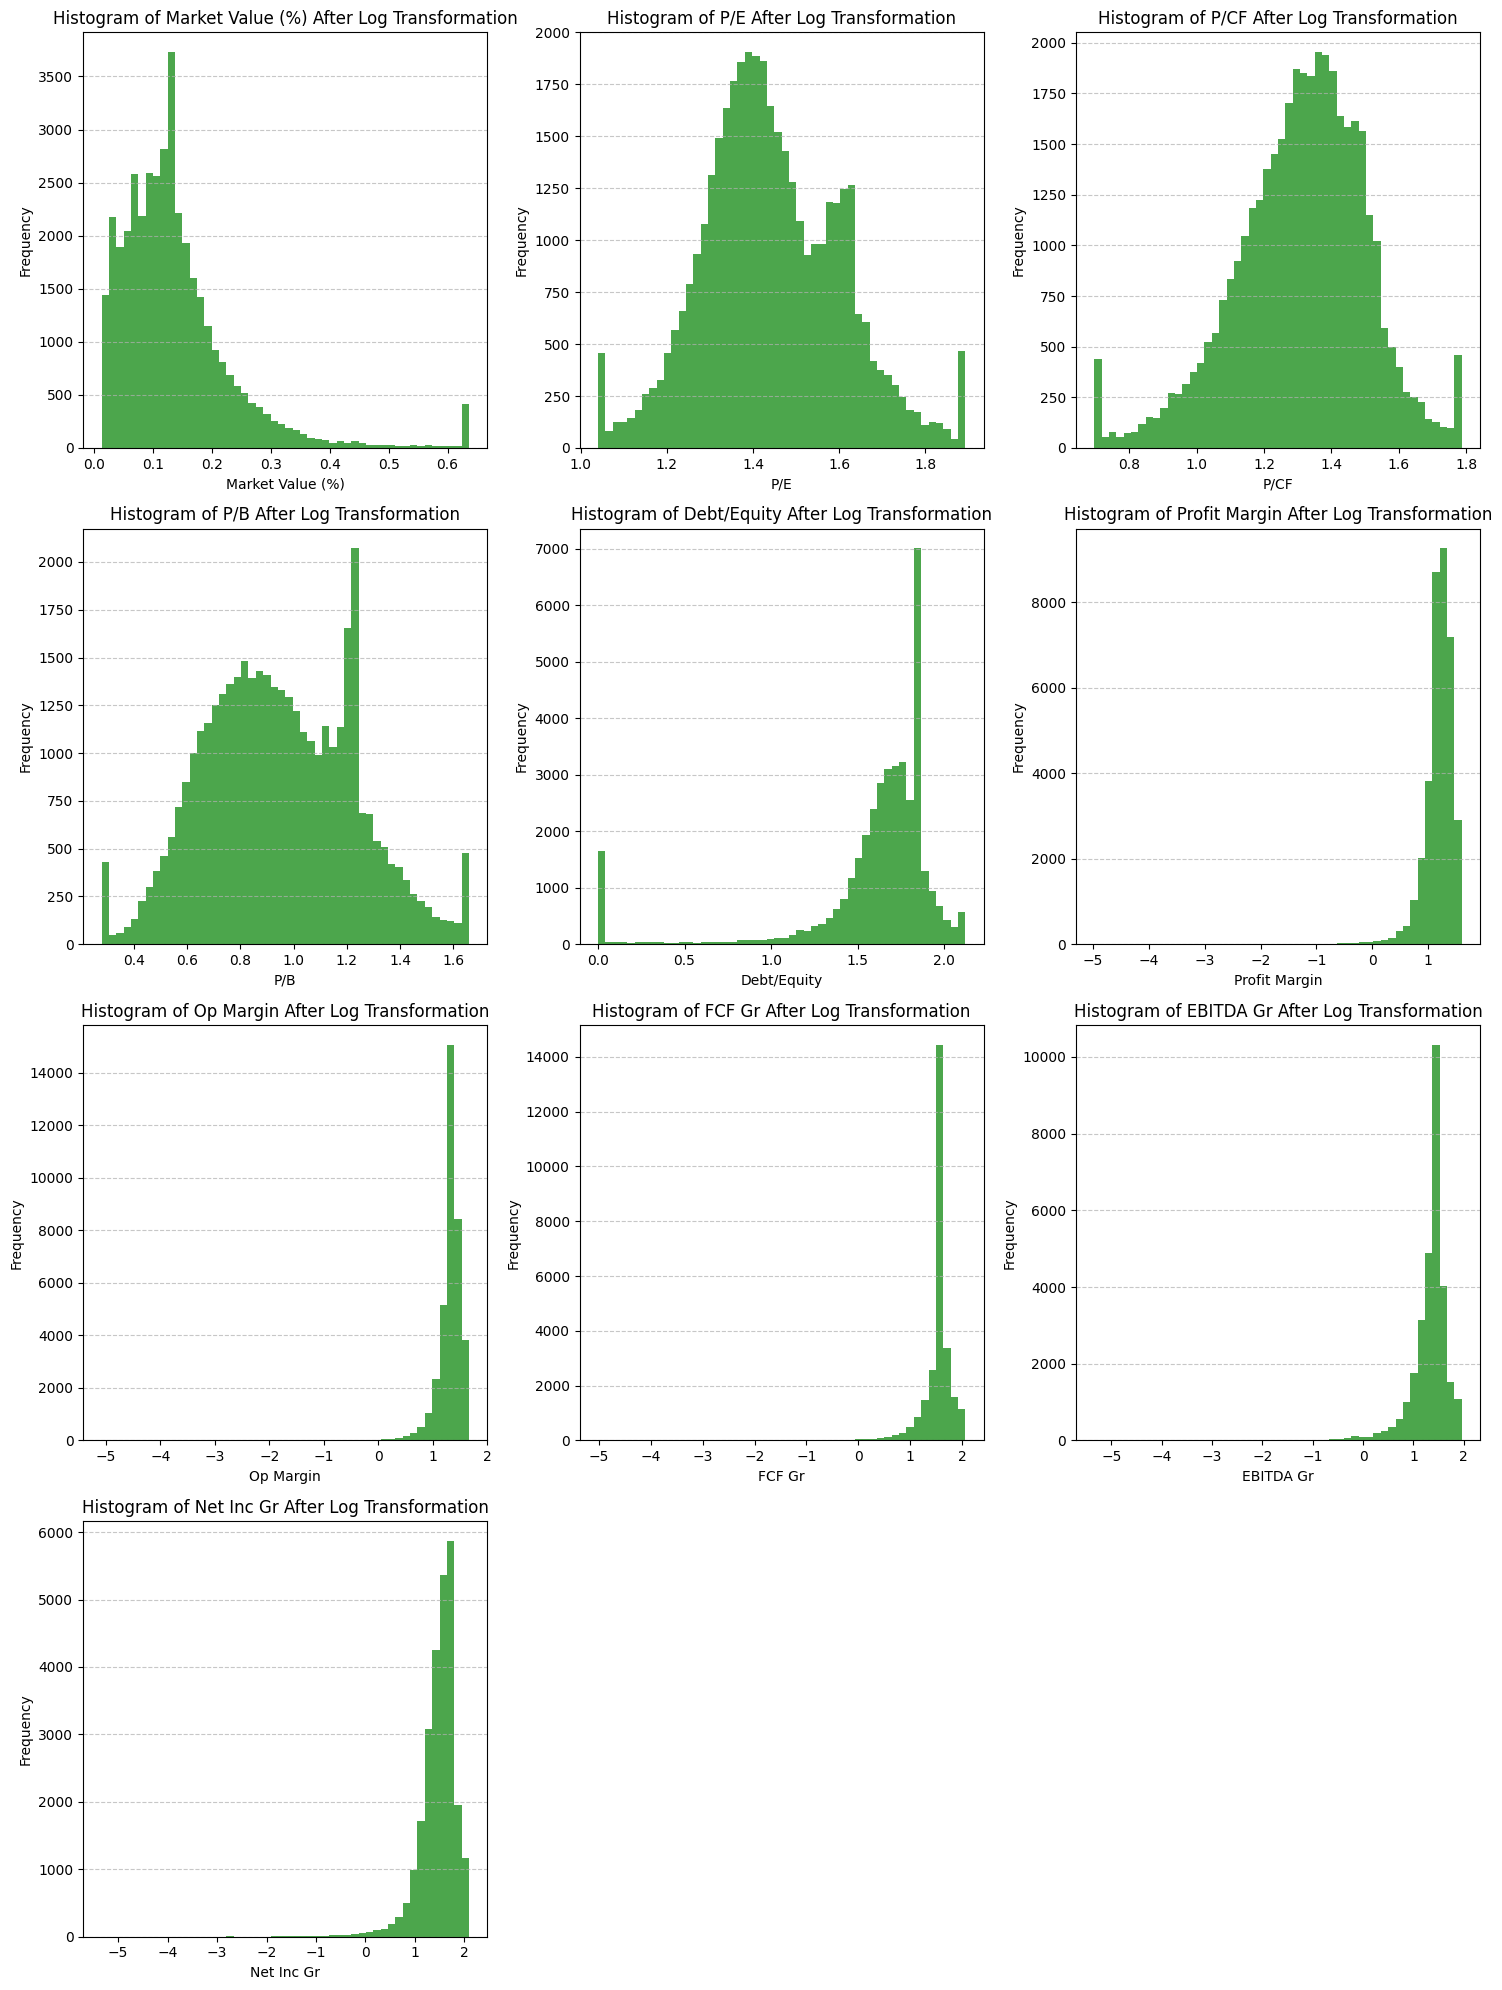

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# List of features to apply log transformation
features_to_transform = ['Market Value (%)', 'P/E', 'P/CF', 'P/B', 'Debt/Equity',
                         'Profit Margin', 'Op Margin', 'FCF Gr', 'EBITDA Gr', 'Net Inc Gr']

# Apply log transformation to each feature
for feature in features_to_transform:
    # Use log1p to handle zero or negative values (log1p = log(1 + x))
    df[feature] = np.log1p(df[feature])

# Plot all histograms in one graph
num_features = len(features_to_transform)
cols = 3  # Number of columns in the grid
rows = (num_features + cols - 1) // cols  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, feature in enumerate(features_to_transform):
    axes[i].hist(df[feature], bins=50, color='green', alpha=0.7)
    axes[i].set_title(f"Histogram of {feature} After Log Transformation")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Frequency")
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

C:\Users\amita\AppData\Local\Temp\ipykernel_29432\3802837555.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Feature', y='Value', data=melted_df, palette='Set2')


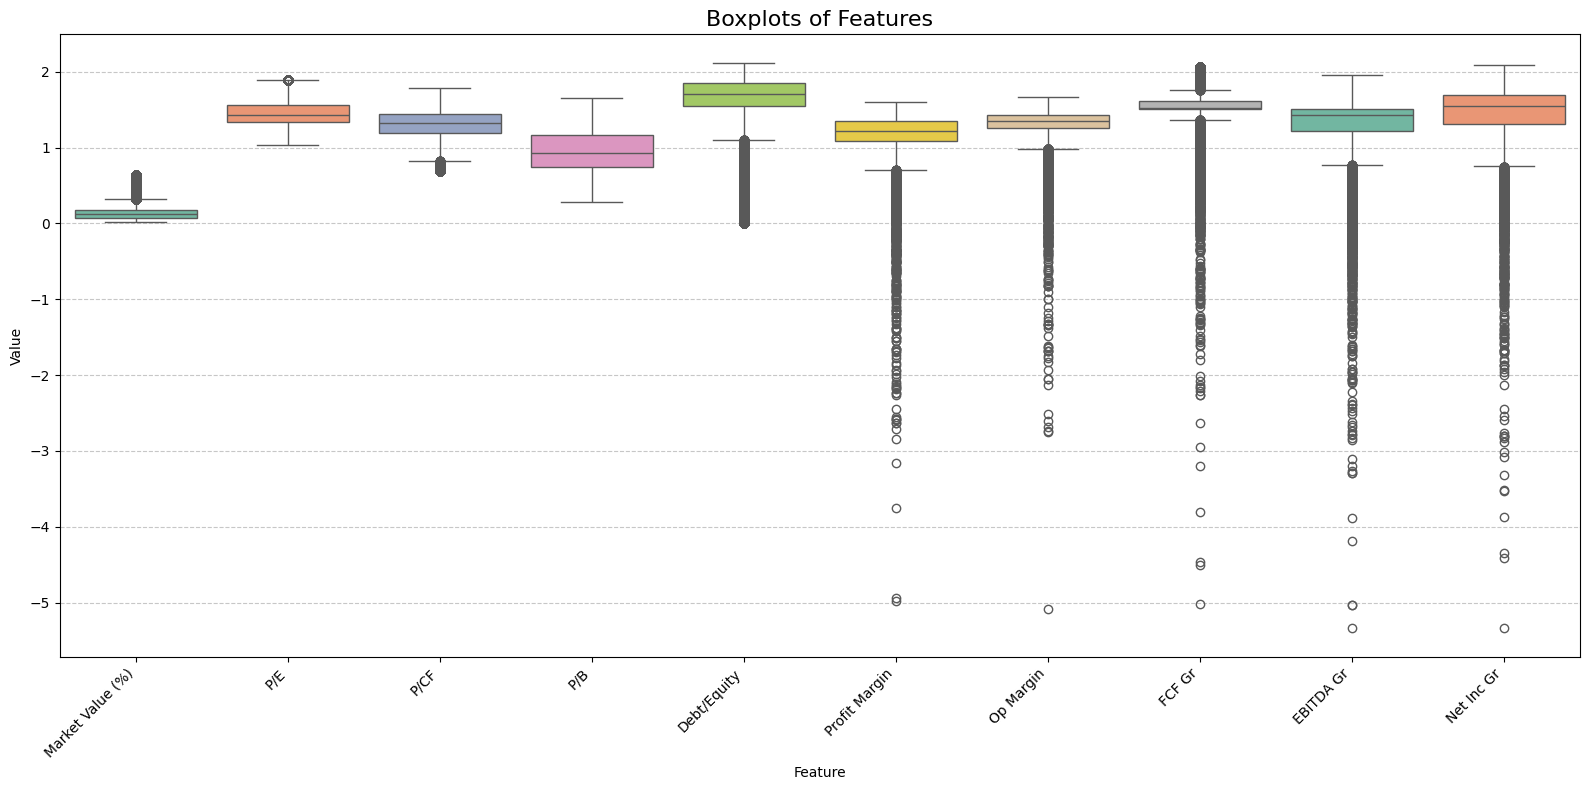

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the DataFrame to reshape it for a single boxplot
melted_df = df[features_to_transform].melt(var_name='Feature', value_name='Value')

# Plot all boxplots in one graph
plt.figure(figsize=(16, 8))
sns.boxplot(x='Feature', y='Value', data=melted_df, palette='Set2')
plt.title('Boxplots of Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Label Encoding:
For binary categorical variables like COVID_Period, label encoding was used.
Label encoding is efficient for binary variables.

In [157]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['COVID_Period'] = le.fit_transform(df['COVID_Period'])

One-Hot Encoding:

Categorical variables like Sector were one-hot encoded to allow the model to interpret them numerically.

In [160]:
df['Sector'].value_counts(normalize=True) * 100

Sector
Other                                       34.465165
Software & IT Services                      12.500319
Residential & Commercial REIT                5.178704
Machinery, Equipment & Components            4.821552
Healthcare Equipment & Supplies              4.642976
Investment Banking & Investment Services     4.107248
Electrical Utilities & IPPs                  4.107248
Insurance                                    4.107248
Pharmaceuticals                              3.568969
Hotels & Entertainment Services              3.392944
Food & Tobacco                               3.214368
Semiconductors & Semiconductor Equipment     3.214368
Banking Services                             3.214368
Professional & Commercial Services           3.214368
Media & Publishing                           3.214368
Oil & Gas                                    3.035792
Name: proportion, dtype: float64

In [161]:
df = pd.get_dummies(df, columns=['Sector'], drop_first=True)

In [55]:
file_path = "C:/Users/amita/team_lambda/Data/stock_cleaned.xlsx"
df= pd.read_excel(file_path)

In [56]:
# Calculate scale_pos_weight
num_negatives = df['Label'].value_counts()[0]
num_positives = df['Label'].value_counts()[1]
scale_pos_weight = num_negatives / num_positives

In [53]:
# Convert object columns to category
df['Quarter'] = df['Quarter'].astype('category')
df['PE_Category'] = df['PE_Category'].astype('category')

# Split the data into training and testing sets
X = df.drop(columns=['Label'])
y = df['Label']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train XGBoost with categorical support
from xgboost import XGBClassifier
model = XGBClassifier(enable_categorical=True, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [57]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split the data into training and testing sets
X = df.drop(columns=['Label'])
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the XGBoost classifier with scale_pos_weight
scale_pos_weight = num_negatives / num_positives
model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7746
           1       0.41      0.36      0.39        94

    accuracy                           0.99      7840
   macro avg       0.70      0.68      0.69      7840
weighted avg       0.99      0.99      0.99      7840



In [162]:

output_file_path = "C:/Users/amita/team_lambda/Data/stock_and_econ_cleaned.xlsx"
df.to_excel(output_file_path, index=False)
print(f"Cleaned dataset saved to {output_file_path}")

Cleaned dataset saved to C:/Users/amita/team_lambda/Data/stock_and_econ_cleaned.xlsx
